<a href="https://colab.research.google.com/github/FreddeFrallan/Multilingual-CLIP/blob/main/Multilingual_CLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multilingual CLIP

## Install Requirements and Download OpenAI CLIP Model
This section might take some minutes.

In [ ]:
#@title  { display-mode: "code" }

import subprocess
CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

!pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex
!pip install ftfy==5.8
!pip install transformers

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os, random
import torch

import warnings
warnings.filterwarnings("ignore")

!pip install git+https://github.com/openai/CLIP.git
import clip

!git clone https://github.com/FreddeFrallan/Multilingual-CLIP
%cd Multilingual-CLIP
!bash get-weights.sh

### Load The Multilingual Text Encoder

In [ ]:
from src import multilingual_clip
text_model = multilingual_clip.load_model('M-BERT-Distil-40')

### Load The Matching CLIP Model

In [ ]:
clip_model, compose = clip.load('RN50x4')

input_resolution = clip_model.input_resolution.item()
context_length = clip_model.context_length.item()
vocab_size = clip_model.vocab_size.item()

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in clip_model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

### Read in the Images

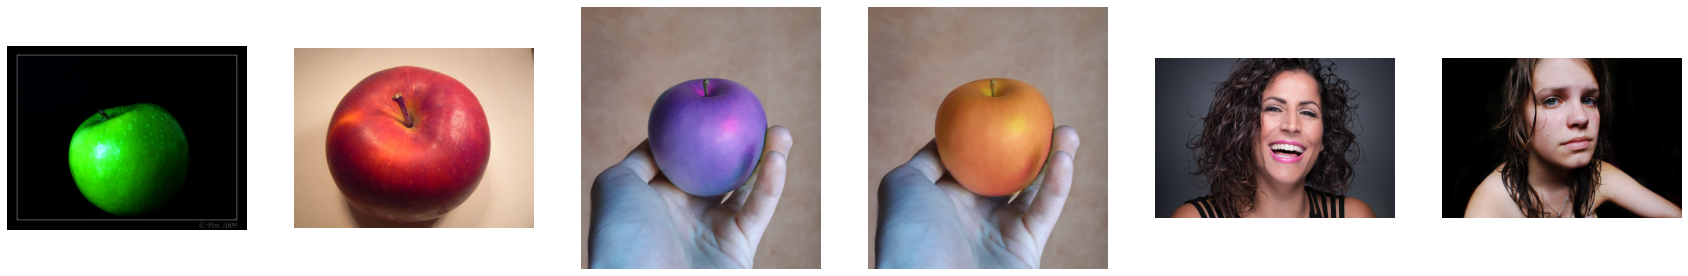

In [33]:
main_path = '/content/Multilingual-CLIP/Images/'
demo_images = {
    'Green Apple': 'green apple.jpg',
    'Red Apple': 'red apple.jpg',
    'Purple Apple': 'purple apple.png',
    'Orange Apple': 'Orange Apple.png',
    'Happy Person': 'happy person.jpg',
    'Sad Person': 'sad.jpg',
}
images = {name: Image.open(main_path + p) for name, p in demo_images.items()}

fig = plt.figure()
fig.set_size_inches(30,5)
for i, img in enumerate(images.values()):
  a=fig.add_subplot(1,len(images), i+1)
  plt.imshow(img, )
  plt.axis('off')

### Create Captions

In [34]:
english_captions = [
  'A green apple', 'A red apple', 'A purple apple', 'A orange apple', 'A happy person', 'A very sad person'
]
multilingual_captions = [
  'Красное яблоко' # Russian
  'Une pomme verte' # French
  'Ein lila Apfel' # German
  'Una manzana de color naranja' # Spanish
  'En glad person' # Swedish
  'Ένας λυπημένος άνθρωπος' # Greek
]

### Prepare Images for CLIP

In [ ]:
img_input = torch.stack([compose(img).to('cpu') for img in images.values()])
print(img_input.shape)

### Generate Text & Vision Embeddings

In [ ]:
with torch.no_grad():
    image_embs = clip_model.encode_image(img_input).float().to('cpu')

    english_embs = text_model(english_captions)
    multiingual_embs = text_model(english_captions)

print("CLIP-Vision: {}   M-Clip: {}".format(image_embs.shape, english_embs.shape))

### Compare Predictions

In [85]:
def compare_embeddings(logit_scale, img_embs, txt_embs):
  # normalized features
  image_features = img_embs / img_embs.norm(dim=-1, keepdim=True)
  text_features = txt_embs / txt_embs.norm(dim=-1, keepdim=True)

  # cosine similarity as logits
  logits_per_image = logit_scale * img_embs @ txt_embs.t()
  logits_per_text = logit_scale * txt_embs @ img_embs.t()

  # shape = [global_batch_size, global_batch_size]
  return logits_per_image, logits_per_text

In [ ]:
logit_scale = clip_model.logit_scale.exp().float().to('cpu')

eng_img_logits, eng_img_logits = compare_embeddings(logit_scale, image_embs, english_embs)
mult_img_logits, mult_img_logits = compare_embeddings(logit_scale, image_embs, multiingual_embs)


### Visualize Results

In [ ]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(images):
    plt.imshow(image.permute(1, 2, 0), extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

In [ ]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

In [ ]:
swe_cifar_classes = ['äpple', 'akvariefisk', 'bebis', 'Björn', 'bäver', 'säng',
                     'bi', 'skalbagge', 'cykel', 'flaska', 'skål', 'pojke',
                     'bro', 'buss', 'fjäril', 'kamel', 'burk', 'slott', 'larv',
                     'nötkreatur', 'stol', 'schimpans', 'klocka', 'moln',
                     'kackerlacka', 'soffa', "krabba", 'krokodil', 'kopp', 
                     'dinosaurie', 'delfin', 'elefant', 'plattfisk', 'skog',
                     'räv', 'flicka', 'hamster', 'hus', 'känguru', 
                     'tangentbord', 'lampa', 'gräsklippare', 'leopard', 'lejon',
                     'ödla', 'hummer', 'man', 'lönnträd', 'motorcykel', 'fjäll',
                     'mus', 'svamp', 'ekträd', 'orange', 'orkide', 'utter',
                     'palmträd', 'päron', 'pickup', 'tall', 'enkel', 'tallrik',
                     'vallmo', "piggsvin", 'opossum', 'kanin', 'tvättbjörn',
                     'stråle', 'väg', 'raket', 'reste sig', 'hav', 'säl', 'haj',
                     'argbigga', 'skunk', 'skyskrapa', 'snigel', 'orm', 'Spindel',
                     'ekorre', 'spårvagn', 'solros', 'Sötpeppar', 'tabell',
                     'tank', 'telefon', 'tv', 'tiger', 'traktor', 'tåg', 'öring',
                     'tulpan', 'sköldpadda', 'garderob', 'val', 'pilträd', 'Varg',
                     'kvinna', 'mask']

In [ ]:
#text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
text_descriptions = [f"Det här är ett foto på {label}" for label in swe_cifar_classes]
#text_tokens = [[sot_token] + tokenizer.encode(desc) + [eot_token] for desc in text_descriptions]
#text_input = torch.zeros(len(text_tokens), model.context_length, dtype=torch.long)

#for i, tokens in enumerate(text_tokens):
#    text_input[i, :len(tokens)] = torch.tensor(tokens)

#text_input = text_input.cuda()
#text_input.shape

In [ ]:
with torch.no_grad():
    #text_features = model.encode_text(text_input).float()
    text_features = sweclip(text_descriptions).float().cpu()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features.cpu() @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

In [ ]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [swe_cifar_classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()